In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

- 读入每年的数据计算年际相关性

In [2]:
filename_era5i = "merge_hgt_daily.nc"
filename_vr     = "hgt_VR_98-17.nc"
filename_rcm    = "hgt_RCM_98-17.nc"

ds_or = {}
dir_in = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/hgt/"
ds_or['era5i']  = xr.open_dataset(dir_in + filename_era5i)
dir_in = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/diag_daily_selected/hgt/"
ds_or['vr']     = xr.open_dataset(dir_in + filename_vr)
dir_in = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/diag_daily_selected/hgt/"
ds_or['rcm']    = xr.open_dataset(dir_in + filename_rcm  )
# 提取变量
var_total = {}
var_total['era5i'] = ds_or['era5i']['hgt'].sel(level=500)
var_total['vr'] = ds_or['vr']['height_500hPa']
var_total['rcm'] = ds_or['rcm']['height_500hPa']
# change coords
var_list = ['era5i', 'vr', 'rcm']
for i in var_list:
    rename_dict = dict(zip(var_total[i].coords.keys(), var_total['era5i'].coords.keys()))
    # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var_total[i] = var_total[i].rename(rename_dict)
    var_total[i]._coords = var_total['era5i']._coords
    var_total[i] = var_total[i].rename(i)


time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
level -----converting to----- level
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat


In [3]:
# 拆分 4-5 月 以及 6-8 月
var_selmonth = {}
var_selmonth['am'] = {}
var_selmonth['jja'] = {}

time_idx_am = var_total['era5i'].time.dt.month.isin([4,5])
time_idx_jja = var_total['era5i'].time.dt.month.isin([6,7,8])

for mod_name in ['era5i', 'vr', 'rcm']:
    var_selmonth['am'][mod_name]  = var_total[mod_name].isel(time = time_idx_am)
    var_selmonth['jja'][mod_name] = var_total[mod_name].isel(time = time_idx_jja)

# 获取年际时间序列 var_interannual{} dict
var_interannual = {}
time_for_groupby = {}
time_for_groupby['am'] = var_selmonth['am']['vr'].time.dt.year
time_for_groupby['jja'] = var_selmonth['jja']['vr'].time.dt.year

for iseason in ['am', 'jja']:
    var_interannual[iseason] = {}
    for mod_name in ['era5i', 'vr', 'rcm']:
        var_interannual[iseason][mod_name] = var_selmonth[iseason][mod_name].groupby(time_for_groupby[iseason]).mean(dim = 'time')

def scipy_count_corr_2d(a,b):
    '计算两个3D序列在时间维上的相关性，使用scipy逐个格点的计算，获取pvalues,输入数组a,b 按照 time x lat x lon的方式进行排列'
    '如果第一个时次出现了np.nan ,那么就对这个格点赋值为nan'
    import numpy as np
    from scipy import stats

    dim1 = a.shape[1]
    dim2 = a.shape[2]
    pvalues = np.empty(shape = a.shape[1:])
    corrvalues = np.empty(shape = a.shape[1:])
    # np.corrcoef?
    for ilat in range(0, dim1):
        for ilon in range(0, dim2):
            if ( (np.isnan(a[0,ilat,ilon])) | (np.isnan(b[0,ilat,ilon])) ):
                corrvalues[ilat, ilon], pvalues[ilat, ilon] = np.nan, np.nan
                continue    
            corrvalues[ilat, ilon], pvalues[ilat, ilon] \
                = stats.pearsonr(a[:,ilat,ilon], b[:,ilat,ilon])
    return [corrvalues, pvalues]

corr_interannual = {}

for iseason in ['am', 'jja']:
    corr_interannual[iseason] = {}
    for mod_name in ['vr', 'rcm']:
        corr_interannual[iseason][mod_name]  = {}
        corr_interannual[iseason][mod_name]['corr']    = \
            xr.corr(var_interannual[iseason]['era5i'], var_interannual[iseason][mod_name], dim= 'year')
        corr_scipy, pvalues_scipy = \
            scipy_count_corr_2d(var_interannual[iseason]['era5i'].values, var_interannual[iseason][mod_name].values)
        corr_interannual[iseason][mod_name]['pvalues'] = xr.DataArray(pvalues_scipy, coords = \
            corr_interannual[iseason][mod_name]['corr'].coords, name = 'pvalues')

/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [6]:
# 国内政区图的绘制
# Load the border data, CN-border-La.dat is download from
# https://gmt-china.org/data/CN-border-La.dat
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

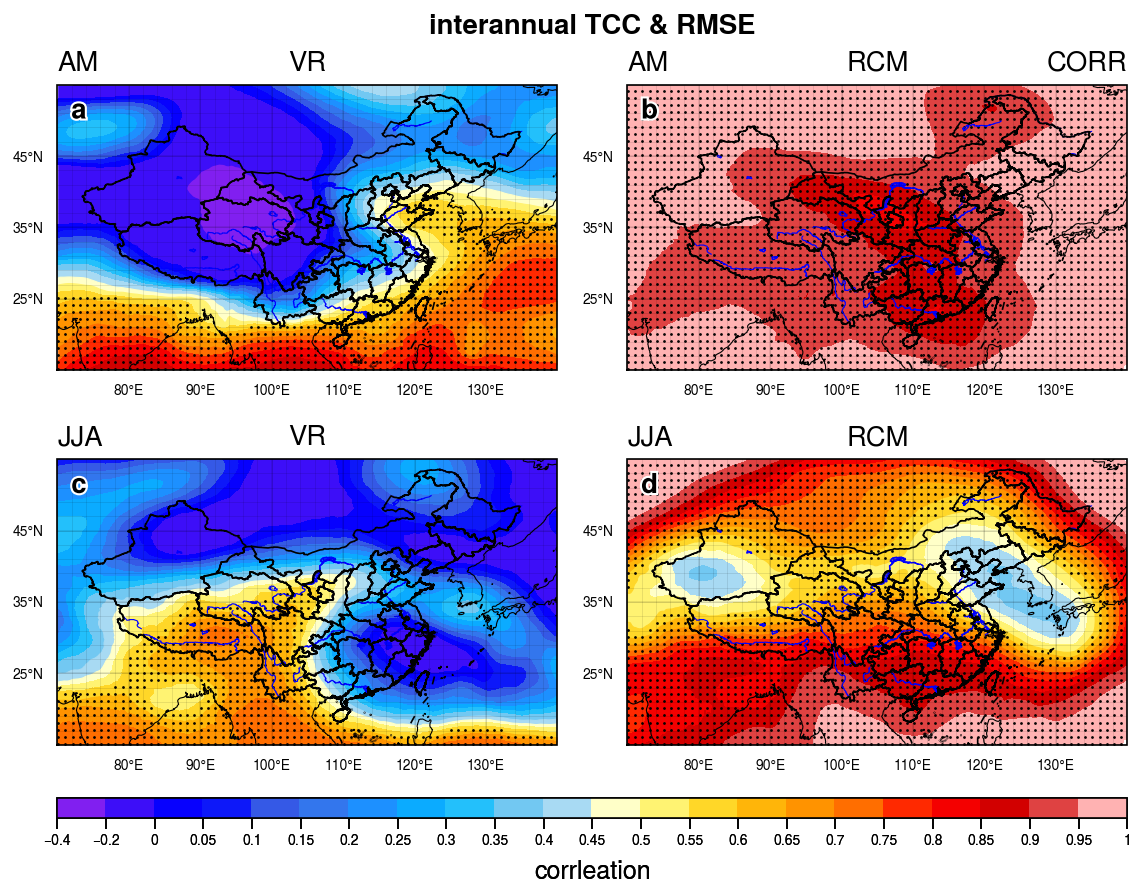

In [7]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
import cmaps
# ----- get filter vars coords-----

lon = corr_interannual['am']['vr']['corr'].lon.values
lat = corr_interannual['am']['vr']['corr'].lat.values

#----- create plot -----
fig, axs = plot.subplots(ncols=2 ,nrows=2, proj=('cyl'))
m_contour_list = [] # 用于保存contour设置，后续设置colorbar使用

#----- 添加海洋以及行政区划 -----
##---- 直接绘图，从边界文件添加

# for ax_ind in axs:
# for line in borders:
    # axs.plot(line[0::100], line[1::100], lw = 0.5, color='gray',transform=ccrs.Geodetic())
    # axs.plot(line[0::10], line[1::10], lw = 0.4, color='black',transform=ccrs.Geodetic())
##---- 使用shp文件添加
    ## shapefile数据下载的位置：
## http://gaohr.win/site/blogs/2017/2017-04-18-GIS-basic-data-of-China.html
# world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/World/country.shp"
river_border_shapefile =  "/raid52/yycheng/MPAS/REFERENCE/MODEL_CONSTANT/R1/" + "hyd1_4l.shp"
southsea_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "southsea_island.shp"
ninelines_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "nine_lines.shp"
## 来源： 沛沛的诸省 + 诸岛
bou24p_shapefile     = "/m2data2/yycheng/data_stage/CN-border/peipeihelp/" + "bou2_4p.shp"
## 来源： https://www.resdc.cn/data.aspx?DATAID=200
province_shapefile     = "/m2data2/yycheng/data_stage/CN-border/CN-sheng/" + "change_proj_CN-sheng-A.shp"

for ax in axs:
    # world     = shpreader.Reader(world_border_shapefile).geometries()
    river     = shpreader.Reader(river_border_shapefile).geometries()
    # bou24p    = shpreader.Reader(bou24p_shapefile).geometries()
    ninelines = shpreader.Reader(ninelines_shapefile).geometries()
    province  = shpreader.Reader(province_shapefile).geometries()
    ax.add_geometries(river, ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)
    # ax.add_geometries(world, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.4, zorder=1)
    # ax.add_geometries(bou24p, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 沛沛map
    ax.add_geometries(province, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 地资所
    ax.add_geometries(ninelines, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1)

#----- colorbar ticks 统一设置 -----
# cmap = 'gist_ncar'
# cmap = new_cmap
# cmap = cmap_data
new_cmap_corr     = cmaps.ncl_default
new_cmap_rmse     = plt.get_cmap('gist_ncar')

# corr_ticks = np.linspace(0.,1, 21)
corr_ticks = np.concatenate( (np.array([-0.4,-0.2]), np.linspace(0,1,21)) , axis = 0)
# rmse_ticks = np.linspace(0, 25, 26)
# rmse_ticks = np.concatenate((np.linspace(0,10,21), [12,14,16,18,20,25]), axis=0)
# print("----- tick levels is : " + str(mean_ticks))

# plot contourf and titile axs
axs[0,:].format(ltitle = 'AM')
axs[1,:].format(ltitle = 'JJA')
axs[:,0].format(title='VR')
axs[:,1].format(title='RCM')
# axs[:,2].format(title='VR')
# axs[:,3].format(title='RCM')
axs[0,1].format(rtitle='CORR')
# axs[0,3].format(rtitle='RMSE')

for season_ind, season_name in enumerate(['am','jja']):
    for mod_ind, mod_name in enumerate(['vr','rcm']):
        # corr
        m_corr  = axs[season_ind, mod_ind].contourf(lon, lat, corr_interannual[season_name][mod_name]['corr'].values,\
        levels=corr_ticks,cmap=new_cmap_corr)
        # 绘制散点
        # 需要将原本密集的格点散点减少 (::4) 然后找到减少后的经纬度lon[::4] 进行散点的绘制
        scatter_test = np.argwhere((corr_interannual[season_name][mod_name]['pvalues'][::4,::4]<0.01).values)
        axs[season_ind, mod_ind].scatter(lon[::4][scatter_test[:,1]],lat[::4][scatter_test[:,0]], s=0.15, color = 'k', marker='o')

        # # rmse
        # m_rmse  = axs[season_ind, mod_ind+2].contourf(lon, lat, rmse_interannual[season_name][mod_name].values,\
        # levels=rmse_ticks,cmap=new_cmap_rmse)

# m_corr = axs[mod_ind+4].contourf(lon, lat, corr_interannual['jja'][mod_name]['corr'].values,\
# levels=mean_ticks,cmap=new_cmap_corr)
# scatter_test = np.argwhere((corr_interannual['jja'][mod_name]['pvalues'][::4,::4]<0.05).values)
# axs[mod_ind+4].scatter(lon[::4][ scatter_test[:,1] ], lat[::4][ scatter_test[:,0] ], s=0.15, color = 'k', marker='o')


# m_rmse  = axs[mod_ind+3].contourf(lon, lat, rmse_interannual['jja'][mod_name].values,\
# levels=rmse_ticks,cmap=new_cmap_corr)

#----- add color bar-----
# fig.colorbar(m_overlay, loc='b', cmap=cmap, width=0.1)

fig.colorbar(m_corr, loc='b', width=0.1,cols = (1,2),
ticklabelsize=5,ticks=corr_ticks, title='corrleation')

# fig.colorbar(m_rmse, loc='b', width=0.1,cols = (3,4),
# ticklabelsize=5,ticks=rmse_ticks, title='RMSE')


# axs[0].colorbar(m_mean, loc='b', width=0.1,
# ticklabelsize=5,ticks=mean_ticks)

# axs[1].colorbar(m_idctn, loc='b', width=0.1,
# ticklabelsize=5,ticks=idctn_ticks)

# axs[2].colorbar(m_idctn_diff, loc='b',width=0.1,
# ticklabelsize=5,ticks=diff_ticks)


# ----- format setting -----
axs.format(
abc=True,
abcloc = 'ul',
#----- 地图底图设置 -----
# reso = 'x-hi',
reso = 'med',
# coast = False,
coast = True,
coastlinewidth = 0.4,
borders = False,
lakes = False,
land  = False,
ocean = False,
# cartopyautoextent = True, 
# borderslinewidth=.5,
labels = True,
longrid  = True,
latgrid  = True,
#-----GEO axis-----
lonlim=(70, 140), latlim=(15, 55),
gridlabelsize = 5,
gridminor = True,
lonlocator = np.arange(70,142,10),
latlocator = np.arange(5,60+2,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(5,60+2,2),
#-----line label-----
# linewidth = 0.5,
# suptitle="3000km-2000km bandpass 500hPa height(1998-06 timemean)",
suptitle="interannual TCC & RMSE",
)

#----- save figure -----
fig.patch.set_facecolor('white')
plt.savefig('./output_pic/hgt500hpa_corr_interannual_11.09.png', dpi=600, facecolor= "white")
# plt.savefig('./output_pic/hgt_idctn.png', dpi=300, facecolor= "white")